# __Step 4.6: 2D representation of docs__

Goals here:
- Use UMAP to plot relationships between:
  - Documents
  - Documents of different topics
  - Documents of the same topics but different time bins

Based on:
- [UMAP on sparse data](https://umap-learn.readthedocs.io/en/latest/sparse.html)

Issues:
- 2/9/23
  - The topic model was generated using older version of BERTopic and it cannot be loaded with the current version.
  - Try instead to get the topic assignment using the probability values.


## ___Set up___

In [1]:
import numpy as np
import scipy.sparse
import sympy
import sklearn.datasets
import sklearn.feature_extraction.text
import umap
import umap.plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from matplotlib import colors
from bertopic import BERTopic
from pathlib import Path

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_6_umap"
work_dir.mkdir(parents=True, exist_ok=True)

# saved model, probability, and embedding files
dir42            = proj_dir / "4_topic_model/4_2_outlier_assign"
topic_model_file = dir42 / "topic_model_updated"
prob_file        = dir42 / "probs.pickle"
embedding_file   = dir42 / "embeddings_scibert.pickle"

# modified topic names
dir43            = proj_dir / "4_topic_model/4_3_model_analysis"
toc_mod_name_file= dir43 / 'fig4_3_topic_heatmap_seaborn_order_condensed.txt'

# topic overtime
dir44            = proj_dir / "4_topic_model/4_4_over_time"

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Read data___

### Embeddings

In [3]:
with open(embedding_file, 'rb') as f:
    embeddings = pickle.load(f)

In [4]:
embeddings.shape

(421658, 768)

### Topic assignments

In [5]:
# The following lead to error
#IndexError: Failed in nopython mode pipeline (step: analyzing bytecode) pop from empty list
#topic_model = BERTopic.load(topic_model_file)

# load prob then figure out the topic from scratch instead
with open(prob_file, "rb") as f:
  probs = pickle.load(f)

probability_threshold = np.percentile(probs, 95)
topics_assign = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]
topics_assign[:10]

[52, 48, 48, 48, 47, 32, 24, 48, 47, 52]

In [6]:
topics_array = np.array(topics_assign)
topics_array.shape

(421658,)

## ___UMAP run___

### Functions

In [7]:
def get_mapper(mapper_dir, n_neighbors=15, min_dist=0.1, metric='cosine', 
               random_state=seed):
  '''Read or generate UMAP fitted obj
  Args:
    mapper_dir (Posix path) - location where mapper file is or should be saved
    n_neighbors (int) - UMAP parameter, for constraining the size of the local 
      neighborhood UMAP will look at when attempting to learn the manifold 
      structure of the data
    min_dist (float) - UMAP parameter, minimum distance apart that points are 
      allowed to be in the low dimensional representation
  Return:
    mapper
  '''
  # Create dir if it does not exist
  mapper_dir.mkdir(parents=True, exist_ok=True)
  mapper_file = mapper_dir / 'mapper_topics_all.pickle'

  # read if exist
  if mapper_file.is_file():
    with open(mapper_file, "rb") as f:
      mapper = pickle.load(f)
  # else create mapper obj and save
  else:
    model  = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       metric=metric, random_state=random_state)
    mapper = model.fit(embeddings)
    with open(mapper_file, "wb") as f:
      pickle.dump(mapper, f)

  return mapper

In [ ]:
# get colors
#To get color bins:
#https://stackoverflow.com/questions/69085926/have-each-histogram-bin-with-a-different-color
#Matplotlib color map
#https://matplotlib.org/stable/gallery/color/colormap_reference.html 
#RGB and RGBA
#https://matplotlib.org/stable/tutorials/colors/colors.html
# rgb or rgba won't work for color_keys later, need hex color
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex
def get_ckeys():
  cm = plt.cm.rainbow
  #cm = plt.cm.turbo
  #cm = plt.cm.hsv
  ckeys = {i:colors.to_hex(cm(i/91)) for i in range(-1,91)}
  return ckeys

In [ ]:
# use default color map
#umap.plot.points(mapper, labels=topics_array)
#mapper_topics_all_plot = work_dir / 'fig_4_6_mapper_topics_all.pdf'

def plot_overall(mapper_dir, mapper, labels, color_key):
  umap.plot.points(mapper, labels=labels, color_key=color_key)
  mapper_topics_all_plot = mapper_dir / 'fig_4_6_mapper_topics_all.pdf'
  plt.savefig(mapper_topics_all_plot)

In [ ]:
def umap_plot_each(mapper_dir, mapper, labels, topic, color):
  color_key={f"topic={topic}":color, "all_others":"lightgray"}

  umap.plot.points(mapper, labels=labels, color_key=color_key)
  mapper_topic_plot = mapper_dir / f'fig_4_6_mapper_topic_{topic}.pdf'
  plt.title(f'Topic {topic}')
  plt.savefig(mapper_topic_plot)
  plt.close()

In [ ]:
# go through topics
def plot_each(mapper_dir, mapper, topics_array, ckeys):
  for topic in range(-1,90):
    topic_labels = []
    color = ckeys[topic+1]

    # Modify labels
    for label in topics_array:
      if label == topic:
        topic_labels.append(f"topic={topic}")
      else:
        topic_labels.append("all_others")

    # Change label list into an array for umap.plot
    labels_array =  np.array(topic_labels)

    # Plotting
    umap_plot_each(mapper_dir, mapper, labels_array, topic, color)

### Default parameters

In [8]:
mapper_dir = work_dir / '_umap_default'
mapper_def = get_mapper(mapper_dir)

In [ ]:
ckeys = get_ckeys()
plot_overall(mapper_dir, mapper_def, topics_array, ckeys)

In [ ]:
plot_each(mapper_dir, mapper_def, topics_array, ckeys)

### Plotting

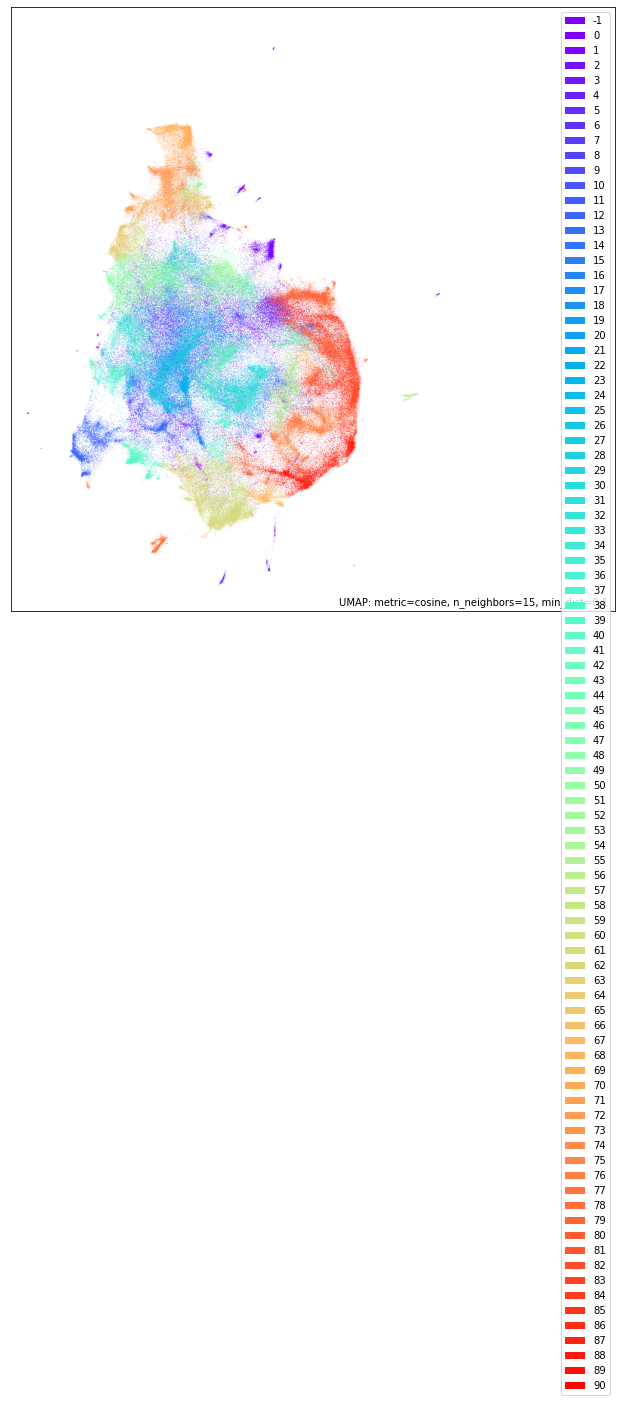

### All topics, color each against all others in different PDFs

## ___Testing___

https://umap-learn.readthedocs.io/en/latest/sparse.html

In [2]:
primes = list(sympy.primerange(2, 110000))
prime_to_column = {p:i for i, p in enumerate(primes)}

In [5]:
lil_matrix_rows = []
lil_matrix_data = []
for n in range(100000):
    prime_factors = sympy.primefactors(n)
    lil_matrix_rows.append([prime_to_column[p] for p in prime_factors])
    lil_matrix_data.append([1] * len(prime_factors))
len(lil_matrix_rows), len(lil_matrix_data)

(100000, 100000)

In [8]:
factor_matrix = scipy.sparse.lil_matrix((len(lil_matrix_rows), len(primes)), 
                                        dtype=np.float32)

In [13]:
factor_matrix.rows = np.array(lil_matrix_rows)
factor_matrix.data = np.array(lil_matrix_data)

/tmp/ipykernel_21841/1462778770.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  factor_matrix.rows = np.array(lil_matrix_rows)
/tmp/ipykernel_21841/1462778770.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  factor_matrix.data = np.array(lil_matrix_data)


In [14]:
factor_matrix.shape

(100000, 10453)

In [15]:
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(
                                                                factor_matrix)

<AxesSubplot: >

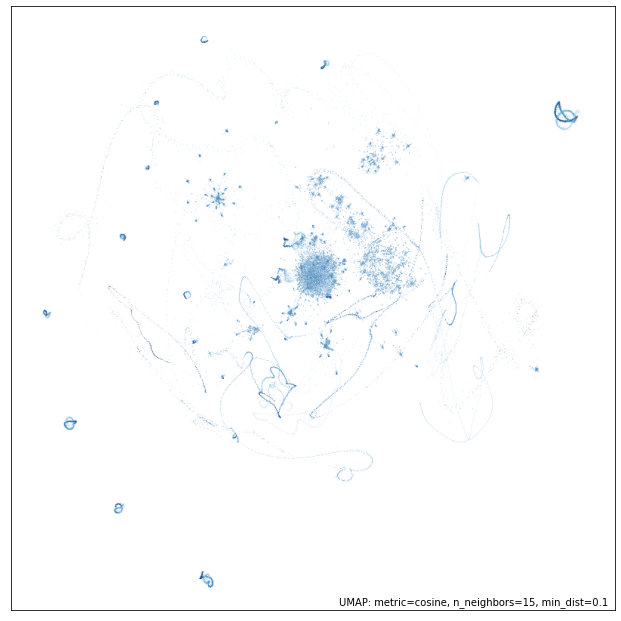

In [17]:
#umap.plot.points(mapper, values=np.arange(100000), theme='viridis')
umap.plot.points(mapper, values=np.arange(100000))

### Testing drawing each topic

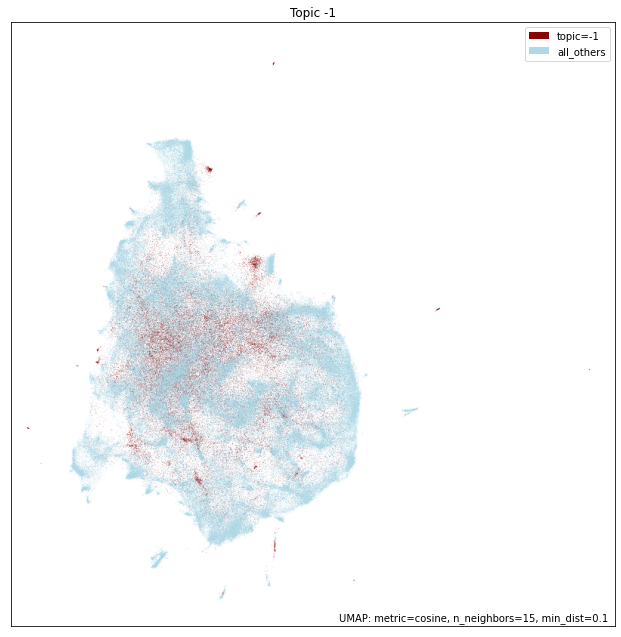

In [ ]:
topic_labels = []
topic = -1
for label in topics_array:
  if label == topic:
    topic_labels.append(f"topic={topic}")
  else:
    topic_labels.append("all_others")

labels_array =  np.array(topic_labels)

umap_plot_each(mapper, labels_array, topic)


### Color map

In [73]:
cmap = plt.cm.viridis
for i in range(0,10):
  print(cmap(1/10))

(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)


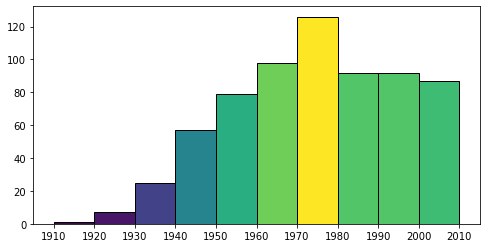

In [71]:
decades = np.arange(1910, 2020, 10)
data = np.random.gamma(4, scale=0.2, size=1000)*110+1910

fig, ax = plt.subplots(figsize=(8,4), facecolor='w')
cnts, values, bars = ax.hist(data, edgecolor='k', bins=decades)
ax.set_xticks(decades)
cmap = plt.cm.viridis

for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(cnt/cnts.max()))

### umap.plot.points

In [20]:
help(umap.plot.points)

Help on function points in module umap.plot:

points(umap_object, labels=None, values=None, theme=None, cmap='Blues', color_key=None, color_key_cmap='Spectral', background='white', width=800, height=800, show_legend=True, subset_points=None, ax=None, alpha=None)
    Plot an embedding as points. Currently this only works
    for 2D embeddings. While there are many optional parameters
    to further control and tailor the plotting, you need only
    pass in the trained/fit umap model to get results. This plot
    utility will attempt to do the hard work of avoiding
    overplotting issues, and make it easy to automatically
    colour points by a categorical labelling or numeric values.
    
    This method is intended to be used within a Jupyter
    notebook with ``%matplotlib inline``.
    
    Parameters
    ----------
    umap_object: trained UMAP object
        A trained UMAP object that has a 2D embedding.
    
    labels: array, shape (n_samples,) (optional, default None)
        A

In [ ]:
ckeys = {-1:gray}
for topic, rgba in enumerate(rgbas):
  # background is set to (0,0,0) so need need to think about it
  #rgb_fore = rgba[:3]
  #alpha    = rgba[3]
  #rgb      = [rgb_f*alpha for rgb_f in rgb_fore]
  ckeys[topic] = rgba